## Talk 8: score-based diffusion models

> **Note**: To run this notebook you'll also need to install PyTorch and `tqdm` using Pip. See previous notebooks for the command needed.

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import (
    Dataset,
    DataLoader,
    default_collate
)
from jax.tree_util import tree_map
from flax import linen as nn
from flax.training import train_state
from flax import struct
import optax
from tqdm import tqdm


First, we'll generate a data set in $X = \mathbb{R}^{2}$ with two clusters, given by the Gaussian mixture density

$$ \Upsilon(x) = \frac{1}{3\sqrt{2\pi}} \exp\left(\frac{\|x - \mu_{1}\|^{2}}{2}\right) + \frac{2}{3\sqrt{2\pi}} \exp\left(\frac{\|x - \mu_{2}\|^{2}}{2}\right) $$

with $\mu_{1} = (-10, 1)$ and $\mu_{2} = (10, 0)$.
We do this by generating $100$ points from the first Gaussian density and $200$ from the second (reflecting the $1/3$ to $2/3$ ratio in the density).

We'll then plot samples from $\Upsilon$ and its noised version $\Upsilon_{\sigma}$ with $\sigma = 3$.

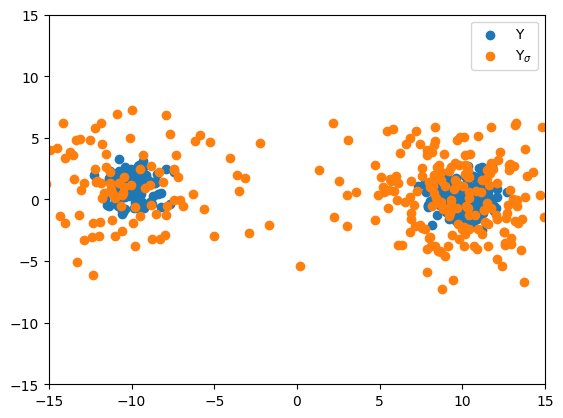

In [2]:
# Generate Gaussian mixure in R^2

SIGMA = 3

N_DATAPOINTS_1 = 100
MU_1 = np.array([-10, 1])

N_DATAPOINTS_2 = 200
MU_2 = np.array([10,0])

X = np.vstack([(MU_1 + np.random.randn(N_DATAPOINTS_1, 2)), (MU_2 + np.random.randn(N_DATAPOINTS_2, 2))])
plt.scatter(X[:,0], X[:,1], label=r'$\Upsilon$')
plt.xlim([-15, 15])
plt.ylim([-15,15])

X_noised = X + np.random.randn(*X.shape) * SIGMA
plt.scatter(X_noised[:,0], X_noised[:,1], label=r'$\Upsilon_{\sigma}$')
plt.legend()


Now we'll convert this data set into a form that is easier to work with for `jax`.

**Technical details**: we use PyTorch's well-developed data loader code to handle shuffling and batching of data ready for use in the neural network.

In [3]:
# `_numpy_collate` and `NumpyLoader` are based on the JAX notebook https://jax.readthedocs.io/en/latest/notebooks/Neural_Network_and_Data_Loading.html
def _numpy_collate(batch):
    return tree_map(np.asarray, default_collate(batch))

class NumpyLoader(DataLoader):
    def __init__(
        self,
        dataset,
        batch_size=1,
        shuffle=False,
        sampler=None,
        batch_sampler=None,
        num_workers=0,
        pin_memory=False,
        drop_last=False,
        timeout=0,
        worker_init_fn=None,
    ):

        # Batch_sampler option is mutually exclusive with
        # batch_size, shuffle, sampler, and drop_last.
        if batch_sampler is not None:
            additional_args = {}
        else:
            additional_args = {
                "batch_size": batch_size,
                "shuffle": shuffle,
                "drop_last": drop_last,
            }

        super(self.__class__, self).__init__(
            dataset,
            sampler=sampler,
            batch_sampler=batch_sampler,
            num_workers=num_workers,
            collate_fn=_numpy_collate,
            pin_memory=pin_memory,
            timeout=timeout,
            worker_init_fn=worker_init_fn,
            **additional_args,
        )

train_dataloader = NumpyLoader(X, batch_size=8, shuffle=True)


Now we'll set up the architecture for the score network $s_{\theta} \colon \mathbb{R}^{2} \to \mathbb{R}^{2}$. We'll use a simple neural network with two hidden layers of width 256.

In [4]:

class ScoreNetwork(nn.Module):

  @nn.compact
  def __call__(self, x):
    x = nn.Dense(features=256)(x)
    x = nn.relu(x)
    x = nn.Dense(features=256)(x)
    x = nn.relu(x)
    x = nn.Dense(features=2)(x)
    return x

Next we'll set up the loss function (eq. (13.22) in https://arxiv.org/pdf/2410.10523v1), and a helper function which takes care of stochastic gradient descent for us.



In [5]:
@jax.jit
def train_step(state, batch, key):
  # LOSS FUNCTION IS DEFINED HERE
  def loss_fn(params):
    noised_batch = batch + SIGMA * jax.random.normal(key)
    score = state.apply_fn({'params': params}, noised_batch)
    return jnp.sum((score + (noised_batch-batch)/SIGMA**2)**2)

  # Computes the value of the loss function, and the gradient with respect to
  # the parameters \theta.
  grad_fn = jax.value_and_grad(loss_fn)
  loss, grads = grad_fn(state.params)

  # Uses the stochastic gradient descent (SGD) optimiser defined below to apply
  # the gradient update to the parameters \theta.
  state = state.apply_gradients(grads=grads)
  return state, loss


def create_train_state(module, rng, learning_rate):
  params = module.init(rng, jnp.ones([1, 2]))['params'] # initialize parameters by passing a template image
  tx = optax.sgd(learning_rate)
  return train_state.TrainState.create(
      apply_fn=module.apply, params=params, tx=tx)




Now we'll initialise the score network, create the training state, and train for 1000 epochs (i.e., 1000 full loops over the training data). We use the `tqdm` package to get a nice-looking progress bar.

In [6]:
key = jax.random.PRNGKey(0)
s_theta = ScoreNetwork()
state = create_train_state(s_theta, key, learning_rate=1e-5)

EPOCHS = 1000

for epoch in range(EPOCHS):
  for step,batch in enumerate((pbar := tqdm(iter(train_dataloader)))):
    key, _ = jax.random.split(key)
    state, loss = train_step(state, batch, key)
    pbar.set_postfix_str(f'loss: {loss:.3f}')

100%|██████████| 38/38 [00:00<00:00, 302.65it/s, loss: 0.069]


Now we use an Euler--Maruyama discretisation of the Langevin dynamics (eq (13.17) of https://arxiv.org/pdf/2410.10523v1) to draw samples from $\Upsilon_{\sigma}$.

The blue scatter points are true samples from $\Upsilon_{\sigma}$; the orange scatter points are independent realisations from Langevin dynamics truncated at a finite time step, with Gaussian initial condition.

(-20.0, 20.0)

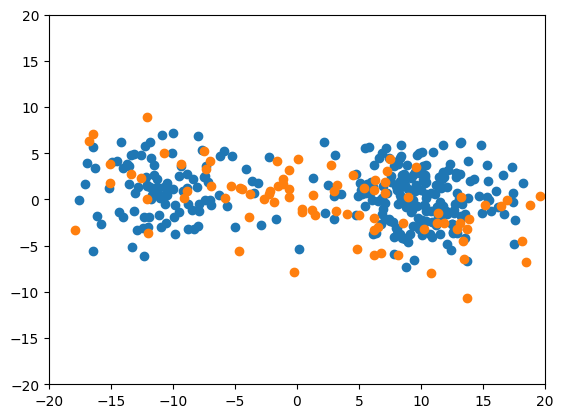

In [8]:
# Sample using Langevin dynamics

def langevin_sample(key, x0, params, step, T):
  history = []
  @jax.jit
  def _inner(key, x):
    output = state.apply_fn({'params': params}, x)
    return x + (step / 2) * output + jnp.sqrt(step) * jax.random.normal(key, x.shape)

  history = [x0]
  for i in range(0, T):
    key, _ = jax.random.split(key)
    history.append(_inner(key, history[-1]))
  return history

N_SAMPLES = 100
x0 = np.random.randn(N_SAMPLES, 2)

x_sampled = langevin_sample(key, x0, state.params, 0.01, 10000)
plt.scatter(X_noised[:,0], X_noised[:,1])
plt.scatter(x_sampled[-1][:,0], x_sampled[-1][:, 1])
plt.xlim([-20, 20])
plt.ylim([-20, 20])

**Conclusions**: there is reasonable agreement between the two distributions, but the Langevin dynamicis samples seem to have much higher probability of staying near the origin. This is because there is very little data around $(0, 0)$, so estimates of the score are not that accurate.

The fix for this is described in the paper https://arxiv.org/pdf/1907.05600, which had significant impact in the machine-learning community. Their solution is to perform denoising score matching *at multiple noise scales simultaneously*, and then use *annealed Langevin dynamics* (start at high noise level and slowly decrease it when generating samples).

This then evolved into the paper https://arxiv.org/pdf/2011.13456, which can be essentially viewed as doing denoising score matching at infinitely many noise scales at once. These tricks are **essential** to get good performance, but we don't cover them in this notebook.

To illustrate the Langevin dynamics in more detail, we follow the path of a single simulation of Langevin dynamics starting at the origin, starting with black points at time $0$ and ending with red points at the final time:

<ipython-input-9-1793460810>:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x[:,0], x[:, 1],c=(i/n_steps,0,0))


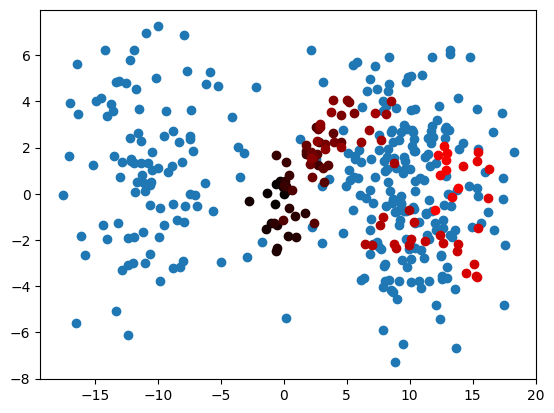

In [9]:
x0 = np.zeros((1, 2))
plot_frequency = 1000
n_steps = 100000
x_sampled = langevin_sample(key, x0, state.params, 0.001, n_steps)

plt.scatter(X_noised[:,0], X_noised[:,1])
for i, x in enumerate(x_sampled):
  if i % plot_frequency != 0:
    continue
  plt.scatter(x[:,0], x[:, 1],c=(i/n_steps,0,0))
